In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from glob import glob

from matplotlib import transforms

from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn import metrics

In [3]:
# To Read out 100 rows rather than the default value. 
pd.set_option('display.max_rows', 1000)

In [4]:
#filenames = glob('D:\Spring 2019\DS 440\Data\kplr_dr25_inj*.csv')
#df = pd.concat([pd.read_csv(f) for f in filenames], ignore_index = True)
df = pd.read_csv('D:\Spring 2019\DS 440\Data\kplr_dr25_inj1_tces.csv', header = 0)

print('Size: ')
print(df.shape)

Size: 
(45377, 26)


In [5]:
'''
plti_inj1 = pd.read_csv('D:\Spring 2019\DS 440\Data\kplr_dr25_inj1_plti.csv', header = 0)
plti_inj2 = pd.read_csv('D:\Spring 2019\DS 440\Data\kplr_dr25_inj2_plti.csv', header = 0)
plti_inj3 = pd.read_csv('D:\Spring 2019\DS 440\Data\kplr_dr25_inj3_plti.csv', header = 0)

print('"kplr_dr25_inj1_plti" Size: ')
print(plti_inj1.shape)

print('\n"kplr_dr25_inj2_plti" Size: ')
print(plti_inj2.shape)

print('\n"kplr_dr25_inj3_plti" Size: ')
print(plti_inj3.shape)
'''

'\nplti_inj1 = pd.read_csv(\'D:\\Spring 2019\\DS 440\\Data\\kplr_dr25_inj1_plti.csv\', header = 0)\nplti_inj2 = pd.read_csv(\'D:\\Spring 2019\\DS 440\\Data\\kplr_dr25_inj2_plti.csv\', header = 0)\nplti_inj3 = pd.read_csv(\'D:\\Spring 2019\\DS 440\\Data\\kplr_dr25_inj3_plti.csv\', header = 0)\n\nprint(\'"kplr_dr25_inj1_plti" Size: \')\nprint(plti_inj1.shape)\n\nprint(\'\n"kplr_dr25_inj2_plti" Size: \')\nprint(plti_inj2.shape)\n\nprint(\'\n"kplr_dr25_inj3_plti" Size: \')\nprint(plti_inj3.shape)\n'

In [6]:
'''temp_df = df.iloc[:, 0:15]
df_drop = temp_df[temp_df.isnull().any(axis=1)]
temp_df = temp_df.drop(df_drop.index.values)
print(temp_df.shape)

X = temp_df.iloc[:, 1:14]
Y = temp_df.iloc[:, 14]
cols_indices = X.columns'''

'temp_df = df.iloc[:, 0:15]\ndf_drop = temp_df[temp_df.isnull().any(axis=1)]\ntemp_df = temp_df.drop(df_drop.index.values)\nprint(temp_df.shape)\n\nX = temp_df.iloc[:, 1:14]\nY = temp_df.iloc[:, 14]\ncols_indices = X.columns'

In [7]:
df['Disp'] = df['Disp'].replace('PC', 1)
df['Disp'] = df['Disp'].replace('FP', 0)

X = df.iloc[:,10:25]
Y = df.iloc[:,2]

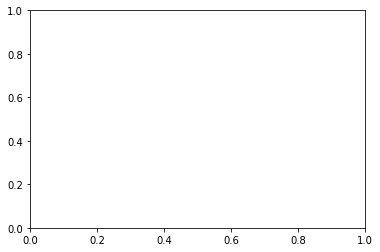

In [8]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 350, num = 5)]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(start = 2, stop = 30, num = 10)]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Minimum number of neighbors required for each node
n_neighbors = [int(x) for x in np.linspace(start = 10, stop = 3, num = 30)]

# Minimum Power parameter required for the Minkowski metric
p = [int(x) for x in np.linspace(start = 10, stop = 1, num = 5)]

knc = KNeighborsClassifier() #n_neighbors, p
abc = AdaBoostClassifier() #n_estimators
xgb = XGBClassifier() #n_estimators, max_depth
dtc = DecisionTreeClassifier() #max_depth, min_samples_split, min_samples_leaf
etc = ExtraTreesClassifier() #n_estimators, max_depth, min_samples_split, min_samples_leaf
rfc = RandomForestClassifier() #n_estimators, max_depth, min_samples_split, min_samples_leaf
gbc = GradientBoostingClassifier() #n_estimators, max_depth, min_samples_split, min_samples_leaf

kfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 7)

plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, len(max_depth)))))

In [ ]:
#Create the param frid
param_grid = dict(n_neighbors = n_neighbors,
                  p = p)

knc_grid_search = GridSearchCV(knc, param_grid, scoring = "neg_log_loss", n_jobs = -1, cv = kfold)
knc_grid_result = knc_grid_search.fit(X, Y)

# summarize results
print("Best: %f using %s" % (knc_grid_result.best_score_, knc_grid_result.best_params_))
means = knc_grid_result.cv_results_['mean_test_score']
stds = knc_grid_result.cv_results_['std_test_score']
params = knc_grid_result.cv_results_['params']
print('KNeighborsClassifier')
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
#Create the param frid
param_grid = dict(n_estimators = n_estimators)

abc_grid_search = GridSearchCV(abc, param_grid, scoring = "neg_log_loss", n_jobs = -1, cv = kfold)
abc_grid_result = abc_grid_search.fit(X, Y)

# summarize results
print("Best: %f using %s" % (abc_grid_result.best_score_, abc_grid_result.best_params_))
means = abc_grid_result.cv_results_['mean_test_score']
stds = abc_grid_result.cv_results_['std_test_score']
params = abc_grid_result.cv_results_['params']
print('AdaBoostClassifier')
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
#Create the param frid
param_grid = dict(n_estimators = n_estimators,
                  max_depth = max_depth)

xgb_grid_search = GridSearchCV(xgb, param_grid, scoring = "neg_log_loss", n_jobs = -1, cv = kfold)
xgb_grid_result = xgb_grid_search.fit(X, Y)

# summarize results
print("Best: %f using %s" % (xgb_grid_result.best_score_, xgb_grid_result.best_params_))
means = xgb_grid_result.cv_results_['mean_test_score']
stds = xgb_grid_result.cv_results_['std_test_score']
params = xgb_grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
#Create the param frid
param_grid = dict(max_depth = max_depth,
                  min_samples_split = min_samples_split,
                  min_samples_leaf = min_samples_leaf)

dtc_grid_search = GridSearchCV(dtc, param_grid, scoring = "neg_log_loss", n_jobs = -1, cv = kfold)
dtc_grid_result = dtc_grid_search.fit(X, Y)

# summarize results
print("Best: %f using %s" % (dtc_grid_result.best_score_, dtc_grid_result.best_params_))
means = dtc_grid_result.cv_results_['mean_test_score']
stds = dtc_grid_result.cv_results_['std_test_score']
params = dtc_grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
#Create the param frid
param_grid = dict(n_estimators = n_estimators,
                  max_depth = max_depth,
                  min_samples_split = min_samples_split,
                  min_samples_leaf = min_samples_leaf)

In [ ]:
etc_grid_search = GridSearchCV(etc, param_grid, scoring = "neg_log_loss", n_jobs = -1, cv = kfold)
etc_grid_result = etc_grid_search.fit(X, Y)

# summarize results
print("Best: %f using %s" % (etc_grid_result.best_score_, etc_grid_result.best_params_))
means = etc_grid_result.cv_results_['mean_test_score']
stds = etc_grid_result.cv_results_['std_test_score']
params = etc_grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
rfc_grid_search = GridSearchCV(rfc, param_grid, scoring = "neg_log_loss", n_jobs = -1, cv = kfold)
rfc_grid_result = rfc_grid_search.fit(X, Y)

# summarize results
print("Best: %f using %s" % (rfc_grid_result.best_score_, rfc_grid_result.best_params_))
means = rfc_grid_result.cv_results_['mean_test_score']
stds = rfc_grid_result.cv_results_['std_test_score']
params = rfc_grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
gbc_grid_search = GridSearchCV(gbc, param_grid, scoring = "neg_log_loss", n_jobs = -1, cv = kfold)
gbc_grid_result = gbc_grid_search.fit(X, Y)

# summarize results
print("Best: %f using %s" % (gbc_grid_result.best_score_, gbc_grid_result.best_params_))
means = gbc_grid_result.cv_results_['mean_test_score']
stds = gbc_grid_result.cv_results_['std_test_score']
params = gbc_grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))